# **SFN 2019**
## *Uncertainty-based arbitration between incremental and episodic control over decisions*
### Mturk sample: Behavior
---
---
#### **Jonathan Nicholas**
Columbia University

In [11]:
import glob, os, ast, warnings, sys
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bambi import Model
from scipy.stats import zscore
import pymc3 as pm
import pystan
import scipy.stats as st

%run utilities/behavioral_analysis_functions.py

palette = ["#66c2a5","#8da0cb"]
sns.set_context("notebook")
sns.set_palette(palette)
sns.set(style="ticks",font="Arial",font_scale=2)

---
# Load Behavioral Data

In [2]:
# load data
n_subjects, data = loadMturkData(environments=["volstab","stabvol"],
                                 data_dir="/users/jonathan/shohamylab/projects/incep/mturk/ambiguity/within/data/")

# Get memory data
mem_data = data[data.phase.isin(["recognition_mem","choice_mem","value_mem"])]
mem_data = mem_data[["phase","rt","subject_id","environment","condition","object_type","value","object","button_pressed","response"]]

# Clean data and add relevant columns
data = cleanData(data=data)

# Get only data with previously seen objects and add relevant columns 
old_data = getOldData(data=data)

---
# Run model to test for sensitivity to old object value in each environment

In [3]:
object_model = Model(old_data, dropna=True)
object_fit = object_model.fit("old_chosen ~ old_value*environment*condition",
                        random=['old_value*environment*condition|subject_id'],
                        family='bernoulli', samples=3000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 8,375.4: 100%|██████████| 50000/50000 [04:26<00:00, 187.31it/s]
Finished [100%]: Average Loss = 8,375.4
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 8,375.4
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [old_value:environment[T.volatile]:condition[T.volstab]|subject_id_offset, old_value:environment[T.volatile]:condition[T.volstab]|subject_id_sd, old_value:condition[T.volstab]|subject_id_offset, old_value:condition[T.volstab]|subject_id_sd, old_value:environment[T.volatile]|subject_id_offset, old_value:environment[T.volatile]|subject_id_sd, old_value|subject_id_offset, old_value|subject_id_sd, environment[T.volatile]:condition[T.volstab]|subject_id_offset, environment[T.volatile]:condition[T.volstab]|subject_id_sd, condition[T.volstab]|subject_id_offs

In [4]:
ppc_object = pm.sampling.sample_ppc(object_model.backend.trace, samples=1000, model=object_model.backend.model)

100%|██████████| 1000/1000 [00:05<00:00, 180.42it/s]


In [5]:
predictors = ['old_value','environment','condition',
              'old_value:environment','old_value:condition','environment:condition',
              'old_value:environment:condition']
pm.summary(object_model.backend.trace,var_names=predictors)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
old_value__0,2.064457,0.175845,0.008682,1.722647,2.405193,332.928059,1.004601
environment__0,0.198046,0.103898,0.004832,0.004724,0.416205,426.896947,1.005969
condition__0,0.210589,0.149376,0.006693,-0.064340,0.516871,466.449703,1.003069
old_value:environment__0,-1.212901,0.182695,0.008697,-1.561688,-0.847957,402.627006,1.006221
old_value:condition__0,-1.094402,0.252045,0.011933,-1.607427,-0.616681,400.271290,1.002732
environment:condition__0,-0.508128,0.148853,0.006342,-0.794751,-0.214892,505.247008,1.003882
old_value:environment:condition__0,1.747593,0.262997,0.011335,1.232227,2.253776,513.829362,1.003167


## Group-level model fit

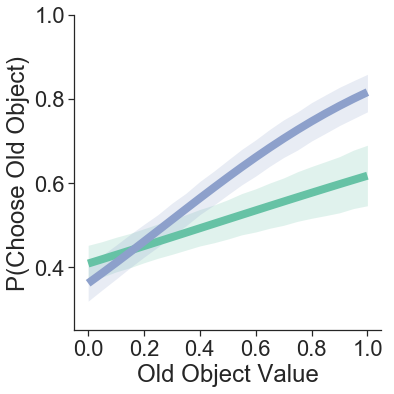

In [9]:
f = plot_2way_logistic_single(data=old_data,
                              ppc=ppc_object, #posterior predictive
                              model_fit=object_fit, #fit model
                              y_var="old_chosen", #outcome variable
                              y_label="P(Choose Old Object)",
                              x_var="old_value", #predictor variable to plot on x-axis
                              x_label="Old Object Value",
                              x_factors=[np.arange(0,1.05,0.05),np.arange(0,1.05,0.05)], # range of x values to plot on
                              x_scaler=[5,5], # if scaling is needed to plot x-axis for each of the ranges
                              col_var="environment", #predictor variable to break into separate plots
                              col_factors=[1,0], # corresponds to factors in the model
                              plot_order=[0,1], # corresponds to order in which col variables should be plotted (plot first value in col_factor on first axis)
                              )
f.savefig("figures/figure1_grp_mturk.pdf")

## Individual model fits and raw data

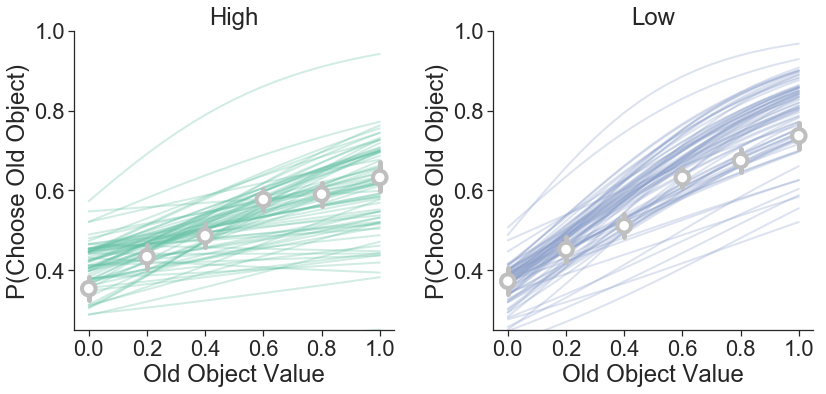

In [12]:
f = plot_2way_logistic(data=old_data,
                       ppc=ppc_object, #posterior predictive
                       model_fit=object_fit, #fit model
                       y_var="old_chosen", #outcome variable
                       y_label="P(Choose Old Object)",
                       x_var="old_value", #predictor variable to plot on x-axis
                       x_label="Old Object Value",
                       x_factors=[np.arange(0,1.05,0.05),np.arange(0,1.05,0.05)], # range of x values to plot on
                       x_scaler=[5,5], # if scaling is needed to plot x-axis for each of the ranges
                       col_var="environment", #predictor variable to break into separate plots
                       col_factors=[1,0], # corresponds to factors in the model
                       plot_order=[0,1], # corresponds to order in which col variables should be plotted (plot first value in col_factor on first axis)
                       col_levels=["stable","volatile"]
                       )
f.savefig("figures/figure1_indivs_mturk.pdf")

## Effect of Old Object Value x Environment

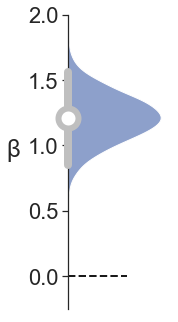

In [10]:
mean = np.mean(-object_model.backend.trace["old_value:environment"]) # reversing effect coding for more interpretable visualization
hpd = pm.stats.hpd(-object_model.backend.trace["old_value:environment"])[0]

f, ax = plt.subplots(1,1,figsize=(3,5))
ax.plot((0,1.35),(0,0),'k--',linewidth=2)
o = ax.plot(0,mean,'o',ms=20,mfc='w',mew=6,zorder=50,color='.75')[0]
o.set_clip_on(False)
l = ax.plot((0,0),(hpd[0],hpd[1]),linewidth=8,color='.75',zorder=49)[0]
l.set_clip_on(False)
sns.distplot(-object_model.backend.trace["old_value:environment"],kde_kws={'linewidth':0,'bw':0.05,'shade':True,'color':palette[1],'alpha':1},ax=ax,kde=True,color=palette[1],vertical=True,hist=False)
ax.set_xticks([])
ax.set_ylim((-0.25,2))
ax.set_ylabel("β   ",rotation=0)
plt.tight_layout()
sns.despine(bottom=True);
f.savefig("figures/figure1_effect_mturk.pdf")

---
# Run model to test for sensitivity to incrementally constructed value

In [13]:
inc_choices = get_inc_choices(data)

model_str1 = "outcome_t1:orange_chosen_t1 + "+ \
             "outcome_t2:orange_chosen_t2 + "+ \
             "outcome_t3:orange_chosen_t3 + " + \
             "outcome_t4:orange_chosen_t4 + " + \
             "outcome_t1:orange_chosen_t1:environment_t1 + "+ \
             "outcome_t2:orange_chosen_t2:environment_t2 + "+ \
             "outcome_t3:orange_chosen_t3:environment_t3 + " + \
             "outcome_t4:orange_chosen_t4:environment_t4"
model_str2 = "("+model_str1+")"+"|subject_id"
inc_model = Model(inc_choices,dropna=True)
inc_fit = inc_model.fit("orange_chosen ~ "+model_str1,random=[model_str2],family='bernoulli',
                        samples=2000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 13,157:  61%|██████    | 30590/50000 [05:01<03:11, 101.36it/s]
Convergence achieved at 30600
INFO:pymc3.variational.inference:Convergence achieved at 30600
Interrupted at 30,599 [61%]: Average Loss = 15,360
INFO:pymc3.variational.inference:Interrupted at 30,599 [61%]: Average Loss = 15,360
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [outcome_t4:orange_chosen_t4:environment_t4[T.volatile]|subject_id_offset, outcome_t4:orange_chosen_t4:environment_t4[T.volatile]|subject_id_sd, outcome_t4:orange_chosen_t4|subject_id_offset, outcome_t4:orange_chosen_t4|subject_id_sd, outcome_t3:orange_chosen_t3:environment_t3[T.volatile]|subject_id_offset, outcome_t3:orange_chosen_t3:environment_t3[T.volatile]|subject_id_sd, outcome_t3:orange_chosen_t3|subject_id_offset, outcome_t3:orange

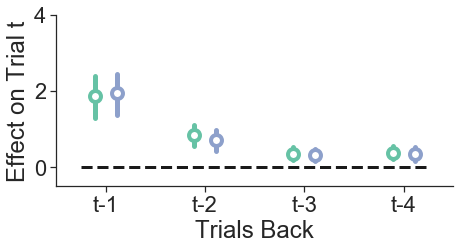

In [14]:
f, axes = plt.subplots(1,1,figsize=(7,4))

plt.plot([-0.25,3.25],[0,0],'k--',linewidth=3)

vars2plt = ['outcome_t1:orange_chosen_t1','outcome_t2:orange_chosen_t2',
            'outcome_t3:orange_chosen_t3','outcome_t4:orange_chosen_t4']
ints2plt = ['outcome_t1:orange_chosen_t1:environment_t1','outcome_t2:orange_chosen_t2:environment_t2',
            'outcome_t3:orange_chosen_t3:environment_t3','outcome_t4:orange_chosen_t4:environment_t4']
for v_i, v in enumerate(vars2plt):
    plt.plot([v_i+0.11,v_i+0.11],pm.stats.hpd(inc_model.backend.trace[v])[0],color=palette[1],linewidth=5)
    plt.scatter(v_i+0.11,np.mean(inc_model.backend.trace[v]),color=palette[1],s=120,linewidth=4)
    
    intvals = inc_model.backend.trace[v]+inc_model.backend.trace[ints2plt[v_i]]
    plt.plot([v_i-0.11,v_i-0.11],pm.stats.hpd(intvals)[0],color=palette[0],linewidth=5)
    plt.scatter(v_i-0.11,np.mean(intvals),color=palette[0],s=120,linewidth=4)
    
plt.setp(axes.collections, facecolor="w",zorder=50)

plt.gca().set_ylim(-0.5,4)
plt.gca().set_xlim(-0.5,3.5)
plt.gca().set_ylabel("Effect on Trial t")
plt.gca().set_xlabel("Trials Back")
plt.gca().set_xticks(range(4))
plt.gca().set_xticklabels(["t-1","t-2","t-3","t-4"])
plt.tight_layout()
sns.despine();

f.savefig("figures/figure2_mturk.pdf")

---
# Compute d-prime and test for difference between environments

In [15]:
recog_data = mem_data[mem_data.phase == "recognition_mem"]
recog_data['response_type'] = recog_data.apply(lambda row: signal_detect(row),axis=1)
sdt_data = recog_data.groupby(["subject_id","environment","response_type"]).size().unstack(fill_value=0).stack().reset_index(name="num_responses")
dprime_df = {'environment':[],'subject_id':[],'dprime':[]}
for subj in sdt_data.subject_id.unique():
    subj_data = sdt_data[sdt_data.subject_id == subj]
    for env in ['stable','volatile']:
        env_data = subj_data[subj_data.environment == env]
        dprime = compute_dprime(n_Hit=env_data[env_data.response_type == "hit"].num_responses.iloc[0],
                                n_Miss=env_data[env_data.response_type == "miss"].num_responses.iloc[0],
                                n_FA=env_data[env_data.response_type == "fa"].num_responses.iloc[0],
                                n_CR=env_data[env_data.response_type == "cr"].num_responses.iloc[0])
        dprime_df['subject_id'].append(subj)
        dprime_df['environment'].append(env)
        dprime_df['dprime'].append(dprime)
dprime_df = pd.DataFrame.from_dict(dprime_df)

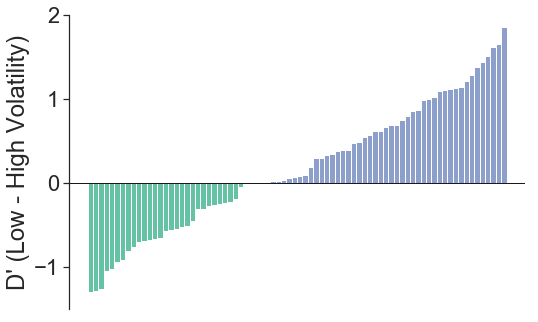

In [27]:
dprime_diffs = np.array(dprime_df[dprime_df.environment == "stable"].dprime) - np.array(dprime_df[dprime_df.environment == "volatile"].dprime)

cols = []
for i in np.sort(dprime_diffs):
    if i <= 0: cols.append(palette[0])
    else: cols.append(palette[1])
        
f, ax = plt.subplots(1,1,figsize=(8,5))
plt.bar(np.arange(len(dprime_diffs)), np.sort(dprime_diffs),width=1,color=cols)
plt.plot((-4,81),(0,0),'k',linewidth=1)
plt.xticks([])
ax.set_ylabel("D' (Low - High Volatility)")
plt.xlim((-4,81))
plt.ylim((-1.5,2))
plt.tight_layout()
sns.despine(bottom=True);
f.savefig("figures/figure3_mturk.pdf")

In [17]:
dprime_model = Model(dprime_df, dropna=True)

dprime_fit = dprime_model.fit("dprime ~ environment",random=['environment|subject_id'],samples=2000, chains=4, target_accept=0.99, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 204.45:  30%|██▉       | 14991/50000 [00:10<00:24, 1428.83it/s]
Convergence achieved at 15100
INFO:pymc3.variational.inference:Convergence achieved at 15100
Interrupted at 15,099 [30%]: Average Loss = 335.28
INFO:pymc3.variational.inference:Interrupted at 15,099 [30%]: Average Loss = 335.28
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dprime_sd, environment[T.volatile]|subject_id_offset, environment[T.volatile]|subject_id_sd, 1|subject_id_offset, 1|subject_id_sd, environment, Intercept]
INFO:pymc3:NUTS: [dprime_sd, environment[T.volatile]|subject_id_offset, environment[T.volatile]|subject_id_sd, 1|subject_id_offset, 1|subject_id_sd, environment, Intercept]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:00<00:00, 197.59draws/s]
The estimated number of effective sa

## Effect of environment

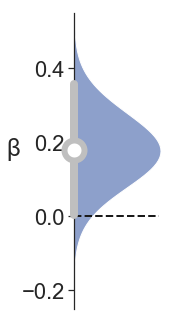

In [18]:
mean = np.mean(-dprime_model.backend.trace['environment'])
hpd = pm.stats.hpd(-dprime_model.backend.trace['environment'])[0]

f, ax = plt.subplots(1,1,figsize=(3,5))
ax.plot((0,3.8),(0,0),'k--',linewidth=2)
o = ax.plot(0,mean,'o',ms=20,mfc='w',mew=6,zorder=50,color='.75')[0]
o.set_clip_on(False)
l = ax.plot((0,0),(hpd[0],hpd[1]),linewidth=8,color='.75',zorder=49)[0]
l.set_clip_on(False)
sns.distplot(-dprime_model.backend.trace['environment'],kde_kws={'linewidth':0,'bw':0.05,'shade':True,'color':palette[1],'alpha':1},ax=ax,kde=True,color=palette[1],vertical=True,hist=False)
ax.set_ylabel("β ",rotation=0)
ax.set_xticks([])
ax.set_ylim((-0.25,0.55))
plt.tight_layout()
sns.despine(bottom=True);
f.savefig("figures/figure3_effect_mturk.pdf")